Desensitization results
=======================

In [5]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
from effect_params import effect_params_str_dict, effect_params_dict
%config InlineBackend.figure_formats = ['svg']
plt.rcParams['figure.constrained_layout.use'] = False

In [ ]:
def get_effect_params(effect):
    effect_params = effect_params_str_dict[effect].copy()
    effect_params_float = list(effect_params_dict[effect])

    if effect == "gain":
        for i in range(len(effect_params)):
            if effect_params_float[i] > 0:
                effect_params.insert(i, "orig")
                effect_params_float.insert(i, 0.0)
                break
    elif effect == "bitcrush":
        effect_params.append("orig")
        effect_params_float.append(16.0)
    elif effect in ("lowpass", "lowpass_cheby"):
        effect_params.append("orig")
        effect_params_float.append(22500.0)
    elif effect == "reverb":
        effect_params.insert(0, "orig")
        effect_params_float.insert(0, 0.0)
    else:
        raise AssertionError(f"Unknown effect {effect}")

    return effect_params, effect_params_float

**Controls for combinations of audio embeddings, audio effects and instruments and desensitization methods to plot.**

The plot is organized as follows: each row corresponds to a combination of audio embedding, audio effect and instrument, and each group of two columns corresponds to a set of desensitization methods, the first column corresponding to training on the uneffected dataset and testing on the effected dataset and the second column corresponding to training on the effected dataset and testing on the uneffected dataset.

To change the combinations displayed on each row, modify the first four lists in the cell below. Each position in the list corresponds to one row.

To change the desensitization methods displayed in each group of two columns, modify the fifth list `desensitization_methods_params_list` below. The second component of the tuples corresponds to the parameter of the desensitization method, which is always `None` except for `cca_samplewise_svd` where it is the threshold for selecting the SVD singular vectors to project out.

`desensitization_methods_labels_dict` controls the labels displayed in the legend.

`desensitization_methods_color_dict` controls the colors of each curve (Matplotlib colors).

The last three lists control the x- and y-axis ranges of the plots of each row. For the x limits, one can use "" (or any other non-float value) to use the default minimum or maximum x.

You can specify a number of rows different from 3 and a number of columns different from 2x2, but in this case, make sure to update the figure size in the last code cell (location marked with a comment) as required.

In [21]:
embedding_list = ["openl3", "panns", "clap"]
effects_list = ["reverb", "gain", "lowpass_cheby"]
instrument_list = ["cello", "organ", "guitar_acc"]
comb_human_list = ["OpenL3, reverb.\nCello", "PANNs, gain\nOrgan", "CLAP, low-pass\nAcoustic guitar"]

desensitization_methods_params_list = [
    [("none", None), ("avgdirproj", None), ("cca_samplewise_svd", 0.4), ("pcaproj_nonnorm", None)],
    [("none", None), ("cca_samplewise_svd", 0.3), ("cca_samplewise_svd", 0.4), ("cca_samplewise_svd", 0.5)]
]

desensitization_methods_labels_dict = {
    ("none", None): "No desensitization",
    ("avgdirproj", None): "Avg. displacement",
    ("cca_samplewise_svd", 0.3): "Samplewise CCA SVD (t=0.3)",
    ("cca_samplewise_svd", 0.4): "Samplewise CCA SVD (t=0.4)",
    ("cca_samplewise_svd", 0.5): "Samplewise CCA SVD (t=0.5)",
    ("pcaproj_nonnorm", None): "Non-normalized PCA"
}

desensitization_methods_colors_dict = {
    ("none", None): "tab:blue",
    ("avgdirproj", None): "tab:orange",
    ("cca_samplewise_svd", 0.3): "tab:red",
    ("cca_samplewise_svd", 0.4): "tab:purple",
    ("cca_samplewise_svd", 0.5): "tab:brown",
    ("pcaproj_nonnorm", None): "tab:gray"
}

xmins = [0.5, "", ""]
xmaxs = [0.8, "", ""]
ymins = [0.94, 0.97, 0.98]
ymaxs = [0.97, 0.99, 0.992]

In [22]:
def desc_desens_meth_param(method_param):
    if method_param[1] is None:
        return method_param[0]
    else:
        return f"{method_param[0]}_{method_param[1]}"

You can configure the figure size in the cell below (location marked with a comment).

<Figure size 640x480 with 0 Axes>

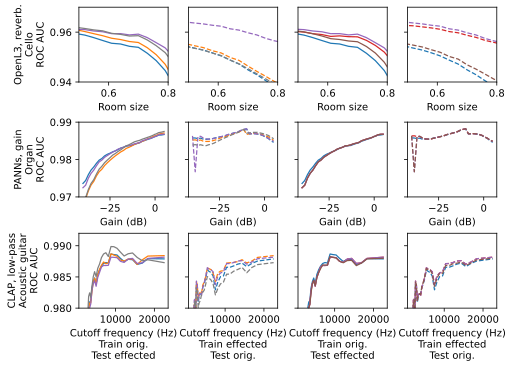

<Figure size 700x200 with 0 Axes>

<Figure size 700x200 with 0 Axes>

<Figure size 700x200 with 0 Axes>

<Figure size 700x200 with 0 Axes>

<Figure size 700x200 with 0 Axes>

<Figure size 700x200 with 0 Axes>

In [23]:
def reload_results(effect, embedding):
    df = pd.read_csv(f"results/{effect}/result_{embedding}.csv", dtype={"train_set": object, "test_set": object})

    auc_dict = dict()
    """instrument -> desensitization method -> train set -> test set -> roc auc"""

    desensitization_methods_params = set()

    for row in df.itertuples():
        # instrument,train_set,test_set,precision,recall,f1_score,support,accuracy,roc_auc,ap,extra_info,embedding,embedding_params,last_updated
        if row.train_set in ('A', 'B'):
            continue
        if row.embedding == embedding:
            desensitization_method = "none"
        else:
            desensitization_method = row.embedding[len(embedding)+1:]
        if pd.isna(row.embedding_params):
            params = None
        else: # For now, the only desensitization method that has parameters is samplewise CCA SVD desensitization
            params = json.loads(row.embedding_params)["svd_thr"]
        desensitization_methods_params.add((desensitization_method, params))
        if row.instrument not in auc_dict:
            auc_dict[row.instrument] = dict()
        if (desensitization_method, params) not in auc_dict[row.instrument]:
            auc_dict[row.instrument][(desensitization_method, params)] = dict()
        if str(row.train_set) not in auc_dict[row.instrument][(desensitization_method, params)]:
            auc_dict[row.instrument][(desensitization_method, params)][str(row.train_set)] = dict()
        auc_dict[row.instrument][(desensitization_method, params)][str(row.train_set)][str(row.test_set)] = row.roc_auc
    
    return auc_dict


plt.subplots_adjust(wspace=0.05, hspace=0.05)
########################################
#    Configure the figure size here    #
########################################
fig, axs = plt.subplots(len(embedding_list), 2*len(desensitization_methods_params_list), figsize=(7, 5), dpi=300, layout="constrained", sharey="row")

for irow in range(len(embedding_list)):
    embedding = embedding_list[irow]
    effect = effects_list[irow]
    effect_params, effect_params_float = get_effect_params(effect)
    inst = instrument_list[irow]
    xmin = xmins[irow]
    xmax = xmaxs[irow]
    ymin = ymins[irow]
    ymax = ymaxs[irow]
    comb_human = comb_human_list[irow]
    
    axs[irow, 0].set_ylim(ymin, ymax)

    for icol in range(len(desensitization_methods_params_list)):
        desensitization_methods_params = desensitization_methods_params_list[icol]

        if effect == "gain":
            xlabel = "Gain (dB)"
        elif effect == "bitcrush":
            xlabel = "Bit depth"
        elif effect in ("lowpass", "lowpass_cheby"):
            xlabel = "Cutoff frequency (Hz)"
        else:
            xlabel = "Room size"
        
        desensitization_methods_params_colors_labels = [(method_param, desensitization_methods_colors_dict[method_param], desensitization_methods_labels_dict[method_param]) for method_param in desensitization_methods_params]

        # Reload results
        auc_dict = reload_results(effect, embedding)

        ax1, ax2 = axs[irow, 2*icol], axs[irow, 2*icol+1]
        fig_legend = plt.figure(figsize=(7, 2))
        handles_1 = []
        handles_2 = []
        labels = []
        # Cross-dataset ROC AUC curves
        for desensitization_method_param, color, label in desensitization_methods_params_colors_labels:
            aucs = [auc_dict[inst][desensitization_method_param]["orig"][p] for p in effect_params]
            handles_1.append(ax1.plot(effect_params_float, aucs, label=label, color=color, lw=1.25)[0])
            labels.append(label)
        for desensitization_method_param, color, label in desensitization_methods_params_colors_labels:
            aucs = [auc_dict[inst][desensitization_method_param][p]["orig"] for p in effect_params]
            handles_2.append(ax2.plot(effect_params_float, aucs, label=label, color=color, lw=1.25, ls="--")[0])
        
        for ax in (ax1, ax2):
            ax.set_xlabel(xlabel)
            if isinstance(xmin, float):
                _, r = ax.get_xlim()
                ax.set_xlim(xmin, r)
            if isinstance(xmax, float):
                l, _ = ax.get_xlim()
                ax.set_xlim(l, xmax)
            
        if irow == len(embedding_list)-1:
            ax1.set_xlabel(xlabel + "\nTrain orig.\nTest effected")
            ax2.set_xlabel(xlabel + "\nTrain effected\nTest orig.")
        
        handles = list(zip(handles_1, handles_2))
        fig_legend.legend(handles, labels, loc="center", handler_map={tuple: HandlerTuple(ndivide=None)}, handlelength=4)

        for format in ("pdf", "png"):
            desens_methods_string = '-'.join([desc_desens_meth_param(m) for m, _, _ in desensitization_methods_params_colors_labels])
            fig_legend.savefig(f"plots/rocauc_curves/legend_{desens_methods_string}.{format}", bbox_inches="tight")
        
    axs[irow, 0].set_ylabel(comb_human + "\nROC AUC")

#fig.tight_layout()
plt.show(fig)
fig.savefig(f"plots/rocauc_curves/rocauc_two_paper.pdf", bbox_inches="tight")

The legend is written to separate files, in `plots/rocauc_curves/legend_{list of desensitization methods}.{pdf|png}`.